In [4]:
import numpy as np 
import pandas as pd 
import plotly as py
import warnings
import os
warnings.filterwarnings("ignore")
py.offline.init_notebook_mode(connected = True)

In [5]:
df = pd.read_csv("../input/Mall_Customers.csv")

In [6]:
df.isnull().sum()
# No null values detected.

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [7]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [8]:
df.tail()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18
199,200,Male,30,137,83


In [9]:
df1 = pd.concat([df,(pd.get_dummies(df[["Gender"]],drop_first=True))],axis=1)

In [10]:
df1.tail()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Gender_Male
195,196,Female,35,120,79,0
196,197,Female,45,126,28,0
197,198,Male,32,126,74,1
198,199,Male,32,137,18,1
199,200,Male,30,137,83,1


In [11]:
# Removing Gender (included as Gender_Male) and CustomerID (insignificant in context).
df1 = df1.drop(["CustomerID","Gender"],axis=1)

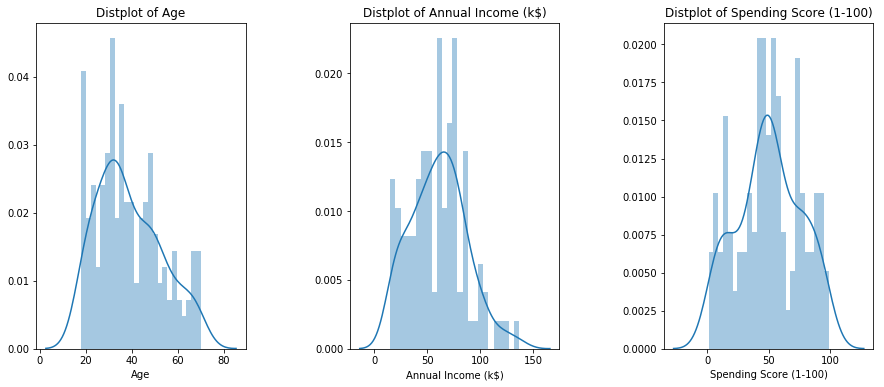

In [12]:
import matplotlib.pyplot as plt 
import seaborn as sns 
plt.figure(1 , figsize = (15 , 6))
n = 0 
for x in ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']:
    n += 1
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
    sns.distplot(df[x] , bins = 25)
    plt.title('Distplot of {}'.format(x))
plt.show()

**Variables following Normal Distribution to quite an extent. No significant skewness**

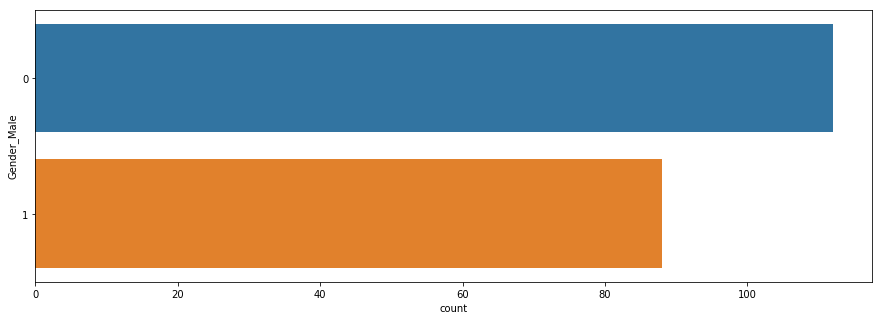

In [13]:
plt.figure(1 , figsize = (15 , 5))
sns.countplot(y = 'Gender_Male' , data = df1)
plt.show()

In [14]:
# Features Scaling of Variables.
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler() 
scaler.fit(df1) 

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning:

Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.



StandardScaler(copy=True, with_mean=True, with_std=True)

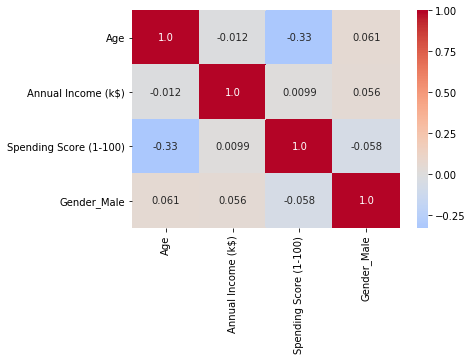

In [15]:
corr= df1.corr()
sns.heatmap(corr, annot=True, fmt='.2', center=0.0, cmap='coolwarm')

**Negligible correlations among variables**

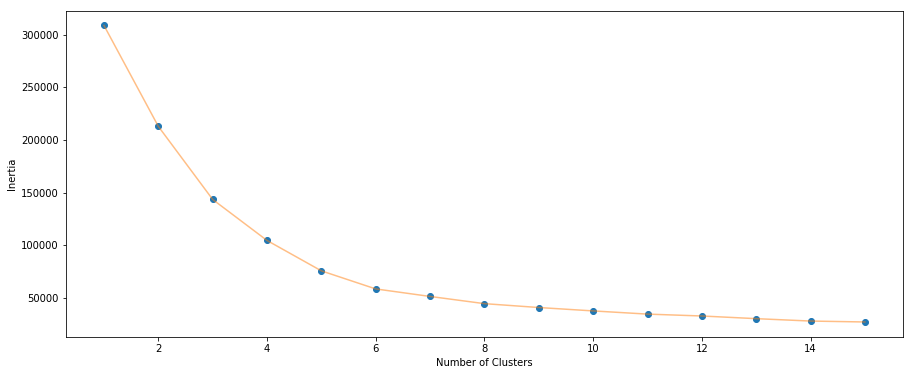

In [16]:
# Deciding the number of clusters to be generatedwith the help of elbow curve.
from sklearn.cluster import KMeans
X4 = df1[['Age' , 'Annual Income (k$)' ,'Spending Score (1-100)','Gender_Male']].iloc[: , :].values
inertia = []
for n in range(1 , 16):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 15 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
    algorithm.fit(X4)
    inertia.append(algorithm.inertia_)
    
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 16) , inertia , 'o')
plt.plot(np.arange(1 , 16) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

In [17]:
from sklearn.cluster import KMeans
X4 = df1[['Age' , 'Annual Income (k$)' ,'Spending Score (1-100)']].iloc[: , :].values
inertia = []
for n in range(1 , 16):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 15 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
    algorithm.fit(X4)
    inertia.append(algorithm.inertia_)

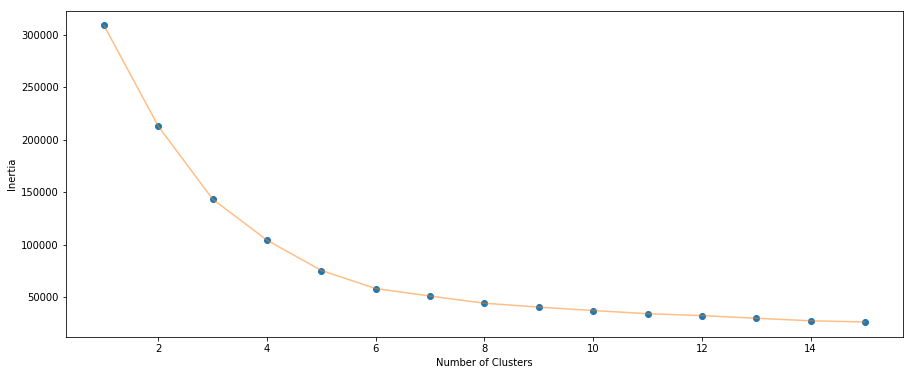

In [18]:
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 16) , inertia , 'o')
plt.plot(np.arange(1 , 16) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

**Taking number of clusters = 5 and plotting with *Spending_Score*, *Age* and *Annual_Income*
beacuse including *Gender_Male* doesn't have a significant effect on elbow curve**

In [19]:
algorithm = (KMeans(n_clusters = 5 ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
algorithm.fit(X4)
labels3 = algorithm.labels_
centroids3 = algorithm.cluster_centers_

In [25]:
import plotly.graph_objs as go
df1['label3'] =  labels3
trace1 = go.Scatter3d(
    x= df1['Age'],
    y= df1['Spending Score (1-100)'],
    z= df1['Annual Income (k$)'],
    mode='markers',
     marker=dict(
        color = df1['label3'], 
        size= 10,
        line=dict(
            color= df1['label3'],
            width= 12
        ),
        opacity=0.8
     )
)
data = [trace1]
layout = go.Layout(
    title= 'Clusters',
    scene = dict(
            xaxis = dict(title  = 'Age'),
            yaxis = dict(title  = 'Spending Score'),
            zaxis = dict(title  = 'Annual Income')
        )
)
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

**Plotting segmentation based on *Annual_Income* and *Spending_Score***

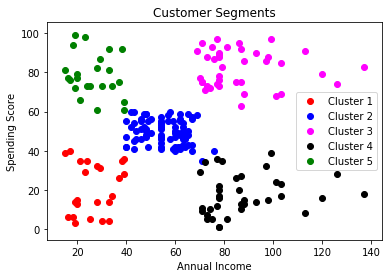

In [28]:
model = KMeans(n_clusters=5, init='k-means++')
clusters = model.fit_predict(df1)
segments = pd.DataFrame()
segments['Annual Income'] = df1['Annual Income (k$)']
segments['Spending Score'] = df1['Spending Score (1-100)']
segments['Cluster'] = clusters
cluster_1 = segments[clusters==0].iloc[:,0:2]
cluster_2 = segments[clusters==1].iloc[:,0:2]
cluster_3 = segments[clusters==2].iloc[:,0:2]
cluster_4 = segments[clusters==3].iloc[:,0:2]
cluster_5 = segments[clusters==4].iloc[:,0:2]

plt.scatter(cluster_1.iloc[:,0],cluster_1.iloc[:,1],c='red',label='Cluster 1')
plt.scatter(cluster_2.iloc[:,0],cluster_2.iloc[:,1],c='blue',label='Cluster 2')
plt.scatter(cluster_3.iloc[:,0],cluster_3.iloc[:,1],c='magenta',label='Cluster 3')
plt.scatter(cluster_4.iloc[:,0],cluster_4.iloc[:,1],c='black',label='Cluster 4')
plt.scatter(cluster_5.iloc[:,0],cluster_5.iloc[:,1],c='green',label='Cluster 5')

plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.title('Customer Segments')
plt.legend()

**Clearly people with low and high annual income tend to have high spending score, whereas people with average annual income have average spending score.**